# Exploring and Cleaning the Products Data:

Import relevant packages:

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import copy 
import statistics
from collections import defaultdict
from geopy.geocoders import Nominatim
import random
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm

Read in Data:

In [3]:
products = pd.read_csv('../Raw_Data/products.csv', lineterminator='\n')

##### Exploring Data:

In [4]:
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time
0,ac2140ae-f0d5-4fe7-ac08-df0f109fd734,"Second-Hand Sofas, Couches & Armchairs for Sal...",NaN,NaN,NaN,NaN,1426592234,2022-02-26
1,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gu...","Home & Garden / Dining, Living Room Furniture ...","Mirror wall art. Posted by Nisha in Dining, Li...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26
2,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, H...",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",1426704579,2022-02-26
3,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gum...",Home & Garden / Garden & Patio / Outdoor Setti...,I have 2 of these - collection only as I don’t...,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26
4,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,"Home & Garden / Dining, Living Room Furniture ...",Great reclaimed army ammunition box used as co...,£115.00,"Radstock, Somerset",1426704575,2022-02-26


In [5]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8091 entries, 0 to 8090
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   8091 non-null   object
 1   product_name         8091 non-null   object
 2   category             7156 non-null   object
 3   product_description  7156 non-null   object
 4   price                7156 non-null   object
 5   location             7156 non-null   object
 6   page_id              8091 non-null   int64 
 7   create_time          8091 non-null   object
dtypes: int64(1), object(7)
memory usage: 505.8+ KB


Plans/Immediate Observations:

- Drop rows where any entry is null. On first glance, the Category, Price, Location and Product Description are the useful pieces of information. (Will be the features)
- Price altered into an a float32. (Float32 as Pytorch works with Float32)
- Could split location into 2 columns: Town and County/City. 
- The "category" field can be split by forward slashes as a product can be included in multiple categories. 
- Transform this notebook into a script so when new data is streamed in, can be cleaned easily. 

In [6]:
products_copy = copy.deepcopy(products)
products = products.loc[products.isna().sum(axis=1) == 0]
products.reset_index(inplace=True, drop=True)

In [7]:
products.shape

(7156, 8)

In [8]:
products.head(5)

,id,product_name,category,product_description,price,location,page_id,create_time
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gu...","Home & Garden / Dining, Living Room Furniture ...","Mirror wall art. Posted by Nisha in Dining, Li...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, H...",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",1426704579,2022-02-26
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gum...",Home & Garden / Garden & Patio / Outdoor Setti...,I have 2 of these - collection only as I don’t...,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26
3,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,"Home & Garden / Dining, Living Room Furniture ...",Great reclaimed army ammunition box used as co...,£115.00,"Radstock, Somerset",1426704575,2022-02-26
4,16dbc860-696e-4cda-93f6-4dd4926573fb,Modern Shannon Sofa for sale at low cost | in ...,"Home & Garden / Dining, Living Room Furniture ...",New Design Shannon Corner sofa 5 Seater Avail...,£450.00,"Delph, Manchester",1426704570,2022-02-26


### Fixing Prices:

Will use regular expressions to extract the price but we should also check that all the prices are in the same currency. 

In [9]:
price_pattern = r'([0-9]*,?[0-9]+)'
products['cleaned_price'] = products['price'].str.extract(price_pattern, expand=True)
products['cleaned_price'] = products['cleaned_price'].str.replace(',','')

In [10]:
products['cleaned_price'] = products['cleaned_price'].astype(np.float32)

In [11]:
currencies = set(products['price'].str[0])
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time,cleaned_price
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gu...","Home & Garden / Dining, Living Room Furniture ...","Mirror wall art. Posted by Nisha in Dining, Li...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26,5.0
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, H...",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",1426704579,2022-02-26,20.0
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gum...",Home & Garden / Garden & Patio / Outdoor Setti...,I have 2 of these - collection only as I don’t...,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26,20.0
3,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,"Home & Garden / Dining, Living Room Furniture ...",Great reclaimed army ammunition box used as co...,£115.00,"Radstock, Somerset",1426704575,2022-02-26,115.0
4,16dbc860-696e-4cda-93f6-4dd4926573fb,Modern Shannon Sofa for sale at low cost | in ...,"Home & Garden / Dining, Living Room Furniture ...",New Design Shannon Corner sofa 5 Seater Avail...,£450.00,"Delph, Manchester",1426704570,2022-02-26,450.0


In [12]:
print(currencies)

{'£'}


All in pounds so need to do anything further with price.

In [13]:
products['cleaned_price'].describe()

count      7156.000000
mean        358.831604
std        5392.854492
min           0.000000
25%          10.000000
50%          40.000000
75%         150.000000
max      399900.000000
Name: cleaned_price, dtype: float64

Based on this: 

- Notice that the price is positively skewed. 
- May need to drop outlier rows where price is 0 and price is extremely high. Lets compute the deciles and create a distribution of the plot. 

In [14]:
np.percentile(products['cleaned_price'], np.arange(0,100,5))

array([  0.  ,   1.  ,   4.  ,   5.  ,  10.  ,  10.  ,  15.  ,  20.  ,
        25.  ,  33.75,  40.  ,  50.  ,  65.  ,  90.  , 110.  , 150.  ,
       200.  , 300.  , 450.  , 850.  ])

As 95% of the prices are between 0-850, I will drop the remaining. 

In [15]:
products = products.loc[products['cleaned_price'] <= 850]
products.shape

(6810, 9)

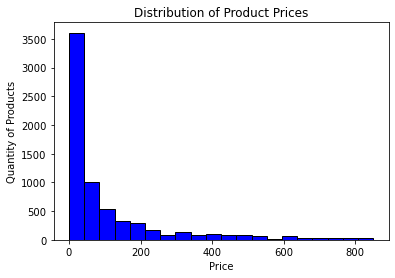

In [16]:
plt.hist(products['cleaned_price'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Price')
plt.ylabel('Quantity of Products')
plt.title('Distribution of Product Prices')
plt.show()

### Extracting Features from Product Descriptions:

In [17]:
products_names = products['product_name']

Generate some random numbers to preview what the rows in our product descriptions look like.

In [18]:
rand_10 = random.sample(range(0,products.shape[0]-1), 10)

In [19]:
sampled_data = products_names[rand_10]
sampled_data

3087        Dewalt power shop saw | in Bridgend | Gumtree
2367    Carrera sulcata | in Aberdare, Rhondda Cynon T...
4041    Pulp Fiction, Tarantino, Polish Poster Framed ...
5554    Electric Mobility Chair | in Allerton, West Yo...
754      DINING CHAIRS | in Bangor, County Down | Gumtree
4571    MacBook Air 11 inch | in Dalkeith, Midlothian ...
347     ALL RANGE OF BEDS! BRAND NEW! CAN DELIVER😄 | i...
4870    HP laptop | in Norris Green, Merseyside | Gumtree
4235    Various GEORGE HARRISON / RINGO ALL ORIGINAL I...
1989    Forest Friends card making | in Hucclecote, Gl...
Name: product_name, dtype: object

Based on this, seems like the text after the first pipe (vertical line |) relates to the location and hence is irrelevant as we have a location column. So we split on this pipe to extract the actual product description. 

In [20]:
products_reduced_name = products['product_name'].str.split('|').str[0]

In [21]:
products_reduced_name.head()

0                                     Mirror wall art 
1                        Stainless Steel Food Steamer 
2                                        Sun loungers 
3    Coffee side table from Ammunition ammo box hai...
4            Modern Shannon Sofa for sale at low cost 
Name: product_name, dtype: object

#### Numerically Encoding Location: 

Planning to split on comma in "location" column. Will use longitude/lattitude. To reduce variance in longitude/lattitude I'll use the major City/Couty. In other words: I'll use the location that follows the comma. If none is present, then I'll use the first county/city. As I removed NULL entries earlier, I know in each row of "location_info", there is always atleast a Major City or a Town listed.


This assumes that prices similar within each major city. If model performs poorly, this could be one improvement.

In [22]:
location_info = products['location'].str.split(',', expand=True)
location_info.head()

,0,1
0,Wokingham,Berkshire
1,Inverness,Highland
2,Skegness,Lincolnshire
3,Radstock,Somerset
4,Delph,Manchester


In [23]:
location_info.columns = ['Town', 'City']
town_counter, city_counter = Counter(location_info['Town']), Counter(location_info['City'])
location_info.shape

(6810, 2)

In [24]:
location_info.head()

,Town,City
0,Wokingham,Berkshire
1,Inverness,Highland
2,Skegness,Lincolnshire
3,Radstock,Somerset
4,Delph,Manchester


In [25]:
location_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6810 entries, 0 to 7155
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Town    6810 non-null   object
 1   City    6574 non-null   object
dtypes: object(2)
memory usage: 417.6+ KB


Using one hot encoding for categories with many levels, can lead to large dimensionality within our data. We know that this leads to needing more computational power. Note of things we can do: 

- Use only most frequent categories. Take top 'x', where x can be determined by a frequency distribution. ie: take the top 'x' such that 80% of the data is accounted for. 
- Use a "Frequency Counts" method, involves replacing the category with its frequency. Negatives of this is that categories with similar counts will be treated alike, so may lose information. 
- Location data can be encoded using longitude and lattitude. 

Cleaning Location Data: Will use longitude/lattitude to encode location:

In [26]:
location_encoding = pd.DataFrame(products['location'])
location_encoding.head()

,location
0,"Wokingham, Berkshire"
1,"Inverness, Highland"
2,"Skegness, Lincolnshire"
3,"Radstock, Somerset"
4,"Delph, Manchester"


Testing extracting longitude and latitude from location.

In [27]:
geolocator = Nominatim(user_agent='my_user_agent')
loc_1 = location_encoding.iloc[1,0]
loc = geolocator.geocode(loc_1)
print(loc_1)
print(loc.latitude)
print(loc.longitude)

Inverness, Highland
57.4790124
-4.225739


In [31]:
locations_stored = {}

def _location_extractor(x : str) -> Tuple[float, float]:
    # Split location based on comma. 
    location_list = x.split(',')
    # If we only have one city/town then use that, else use the major city. 
    if len(location_list) == 1:
        city = location_list[0]
    else:
        city = location_list[1]
    try: 
        try:
            latitude, longitude = locations_stored[city]
            return latitude, longitude
        except:
            coords = geolocator.geocode(city)
            latitude, longitude = coords.latitude, coords.longitude
            locations_stored[city] = [latitude, longitude]
            return latitude, longitude
    except: 
        print(f'For {x}, cant use Gelocator')

In [32]:
products['latitude'], products['longitude'] = list(zip(*products['location'].apply(_location_extractor)))

In [33]:
products.head()

,id,product_name,category,product_description,price,location,page_id,create_time,cleaned_price,latitude,longitude
0,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gu...","Home & Garden / Dining, Living Room Furniture ...","Mirror wall art. Posted by Nisha in Dining, Li...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26,5.0,51.453489,-1.031873
1,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, H...",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",1426704579,2022-02-26,20.0,57.506636,-5.003837
2,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gum...",Home & Garden / Garden & Patio / Outdoor Setti...,I have 2 of these - collection only as I don’t...,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26,20.0,53.182303,-0.203121
3,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,"Home & Garden / Dining, Living Room Furniture ...",Great reclaimed army ammunition box used as co...,£115.00,"Radstock, Somerset",1426704575,2022-02-26,115.0,51.161751,-3.075387
4,16dbc860-696e-4cda-93f6-4dd4926573fb,Modern Shannon Sofa for sale at low cost | in ...,"Home & Garden / Dining, Living Room Furniture ...",New Design Shannon Corner sofa 5 Seater Avail...,£450.00,"Delph, Manchester",1426704570,2022-02-26,450.0,53.479489,-2.245115


### Expanding Categories: 

We notice that following each forward slash there's another category. Using all subsequent categories may not be the smartest idea as this can lead to a large number of features, each with a small sample size. Let's explore further:

In [34]:
unclean_categories = products['category'].str.split(r'/', expand=True)

In [37]:
unclean_categories.shape
unclean_categories.head()

,0,1,2,3,4
0,Home & Garden,"Dining, Living Room Furniture","Mirrors, Clocks & Ornaments",None,None
1,Home & Garden,Other Household Goods,None,None,None
2,Home & Garden,Garden & Patio,Outdoor Settings & Furniture,None,None
3,Home & Garden,"Dining, Living Room Furniture",Other,None,None
4,Home & Garden,"Dining, Living Room Furniture","Sofas, Armchairs & Suites",Private,None


Nulls in table?

In [38]:
unclean_categories.isna().sum(axis=0)

0       0
1       0
2    2552
3    6272
4    6802
dtype: int64

I'll denote each category within the hierachy by an index. We see that for all of our datapoints we have categories at index = 0 and index = 1. As we start seeing

Lets start by extracting the different categories:

In [24]:
unclean_categories = set(products['category'])

In [25]:
print(len(unclean_categories))
category_dict = {}

435


In [26]:
min_categories = np.inf
for i in unclean_categories:
    a = i.split(r'/')
    major_cat, minor_cat = a[0], a[-1]
    num_categories = len(a)
    if num_categories < min_categories:
        min_categories = num_categories
    for category in [major_cat, minor_cat]:
        if category in category_dict.keys():
            category_dict[category] += 1
        else:
            category_dict[category] = 1 

In [27]:
def _category_splitter(x : str) -> Tuple[str, str]:
    category_list = x.split(r'/')
    major_cat, minor_cat = category_list[0], category_list[-1]
    return major_cat, minor_cat

In [28]:
products['major_category'], products['minor_category'] = list(zip(*products['category'].apply(_category_splitter)))

In [29]:
products.head()

,index,id,product_name,category,product_description,price,location,page_id,create_time,cleaned_price,major_category,minor_category
0,1,243809c0-9cfc-4486-ad12-3b7a16605ba9,"Mirror wall art | in Wokingham, Berkshire | Gu...","Home & Garden / Dining, Living Room Furniture ...","Mirror wall art. Posted by Nisha in Dining, Li...",£5.00,"Wokingham, Berkshire",1426704584,2022-02-26,5.0,Home & Garden,"Mirrors, Clocks & Ornaments"
1,2,1c58d3f9-8b93-47ea-9415-204fcc2a22e6,"Stainless Steel Food Steamer | in Inverness, H...",Home & Garden / Other Household Goods,Morphy Richard’s (model no 48755)Stainless ste...,£20.00,"Inverness, Highland",1426704579,2022-02-26,20.0,Home & Garden,Other Household Goods
2,3,860673f1-57f6-47ba-8d2f-13f9e05b8f9a,"Sun loungers | in Skegness, Lincolnshire | Gum...",Home & Garden / Garden & Patio / Outdoor Setti...,I have 2 of these - collection only as I don’t...,£20.00,"Skegness, Lincolnshire",1426704576,2022-02-26,20.0,Home & Garden,Outdoor Settings & Furniture
3,4,59948726-29be-4b35-ade5-bb2fd7331856,Coffee side table from Ammunition ammo box hai...,"Home & Garden / Dining, Living Room Furniture ...",Great reclaimed army ammunition box used as co...,£115.00,"Radstock, Somerset",1426704575,2022-02-26,115.0,Home & Garden,Other
4,5,16dbc860-696e-4cda-93f6-4dd4926573fb,Modern Shannon Sofa for sale at low cost | in ...,"Home & Garden / Dining, Living Room Furniture ...",New Design Shannon Corner sofa 5 Seater Avail...,£450.00,"Delph, Manchester",1426704570,2022-02-26,450.0,Home & Garden,Private


In [32]:
print(set(products['major_category']))

{'Home & Garden ', 'DIY Tools & Materials ', 'Clothes, Footwear & Accessories ', 'Office Furniture & Equipment ', 'Video Games & Consoles ', 'Baby & Kids Stuff ', 'Health & Beauty ', 'Sports, Leisure & Travel ', 'Phones, Mobile Phones & Telecoms ', 'Appliances ', 'Other Goods ', 'Computers & Software ', 'Music, Films, Books & Games '}


In [37]:
products['major_category'].value_counts()

Home & Garden                        834
Office Furniture & Equipment         647
Computers & Software                 619
Music, Films, Books & Games          618
Health & Beauty                      613
DIY Tools & Materials                543
Other Goods                          531
Appliances                           521
Video Games & Consoles               515
Sports, Leisure & Travel             465
Phones, Mobile Phones & Telecoms     440
Clothes, Footwear & Accessories      413
Baby & Kids Stuff                    397
Name: major_category, dtype: int64